In [1]:
from os.path import join
from glob import glob
import json
with open('../dataset_loc','r') as f:
    dataset_loc = f.read().rstrip()
annotation_path = join(dataset_loc, 'annotation_info')
imgs_dir = join(dataset_loc,'Flukes/CRC_combined constrained/')
all_annotations = glob(join(annotation_path, '*'))
annotations_done = {}
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done'] and not annotation[1]['bad']:
            if (not all([info in annotation[1] for info in 
                         ['bottomInfo', 'topInfo', 'leftInfo', 'rightInfo']])):
                continue
            annotations_done[annotation[0]] = annotation[1]

In [2]:
import numpy as np
import cv2
from collections import defaultdict
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

def interpolate(pt1, pt2, axis):
    # manual way
    if axis == 0: # interpolate over x axis
        assert(abs(pt2[1] - pt1[1]) == 1)
        inbtw = [[i, pt2[1]] for i in range(*sorted([pt1[0], pt2[0]]))]
    else:
        assert(abs(pt2[0] - pt1[0]) == 1)
        inbtw = [[pt2[0], i] for i in range(*sorted([pt1[1], pt2[1]]))]
    return inbtw

def contiguous_runs(lis):
    # assume sorted
    slices = []
    initial_slice = 0
    for ind in range(1,len(lis)):
        if abs(lis[ind] - lis[initial_slice]) > 1:
            slices.append(slice(initial_slice, ind))
            initial_slice = ind
        elif ind == (len(lis) - 1):
            slices.append(slice(initial_slice, ind))
            
    return slices
            

def rectangle_intersect(rec1, rec2):
    # assume rectangles are just tuples of upper_left and lower_right x,y coords
    return not (rec2[0][0] > rec1[1][0] or
             rec2[1][0] < rec1[0][0] or
             rec2[0][1] > rec1[1][1] or
             rec2[1][1] < rec1[0][1])
        
        

class ImageInfo:
    def __init__(self, imgid):
        self.imgid = imgid
        self.img = cv2.imread(join(imgs_dir, self.imgid))
        self.shape = self.img.shape[:-1]
        self.info_strs = ['topInfo', 'leftInfo', 'rightInfo', 'bottomInfo']
        self.path_dirs = {'topInfo':0, 'bottomInfo':0, 'leftInfo':1, 'rightInfo':1}
        self.path_coords = {}
        self.interp_paths = {}
        self.bad_regions = []
        
    def load_info(self, info):
        # fill up self.bad_regions, interpolate paths
        for path_type in self.info_strs:
            self.path_coords[path_type] = np.array(info[path_type]['path'])
            bad_inds = list(filter(lambda x: x < len(self.path_coords[path_type]), 
                                   info[path_type]['badPoints']))
            for badpt_run in contiguous_runs(bad_inds):
                # x, y
                bad_pts = self.path_coords[path_type][bad_inds[badpt_run]]
                upper_left = tuple(np.min(bad_pts, axis=0))
                lower_right = tuple(np.max(bad_pts, axis=0))
                self.bad_regions.append((upper_left, lower_right))
                
            interp_path = []
            initial_path_itr = 0
            for path_itr in range(1,len(self.path_coords[path_type])):
                pt1 = self.path_coords[path_type][initial_path_itr]
                pt2 = self.path_coords[path_type][path_itr]
                inbtw = interpolate(pt1, pt2, axis=((self.path_dirs[path_type] + 1) % 2))
                interp_path = chain(interp_path, [pt1] + inbtw + [pt2])
                initial_path_itr += 1
            self.interp_paths[path_type] = list(map(list, interp_path))
                    
    def segment_img(self):
        # make an image of all zeros that's the size of the image
        # not the most space efficient but should be fast
        mask_img = np.zeros(self.shape, dtype=np.int)
        new_img = np.zeros(self.shape, dtype=np.int)
        path_types = {s:ind+1 for ind, s in enumerate(self.info_strs)}
        for path_str in self.info_strs:
            mask_img[zip(*self.interp_paths[path_str])[::-1]] = 1
        self.border_img = mask_img
        #fig = plt.figure(figsize=(15,15))
        #ax = fig.add_subplot(111)
        #ax.imshow(mask_img[:300,:200], interpolation='None')
        for col in range(self.shape[1]):
            marked_rows = np.where(mask_img[:,col] == 1)[0]
            if len(marked_rows) == 0: # our job is done
                continue
            else:
                extent_slice = slice(np.min(marked_rows), np.max(marked_rows)+1)
                new_img[extent_slice,col] = 1
  
        for row in range(self.shape[0]):
            marked_cols = np.where(mask_img[row,:] == 1)[0]
            if len(marked_cols) == 0:
                continue
            else:
                new_img[row,:np.min(marked_cols)] = 0
                new_img[row,np.max(marked_cols)+1:] = 0
        self.segmented_img = new_img
        # make three channel groundtruth
        bg_img = 1 - self.segmented_img
        self.ground_truth = np.dstack([self.border_img, self.segmented_img, bg_img])
        return self.ground_truth

    
    def sample_img(self, sample_size, n_samples, maxtries=10):
        # do a random sample of the image and its segmentation, resampling if we hit a bad region
        samples = [] # list of tuples of image data and corresponding segmentation
        for _ in range(n_samples):
            # select a random point
            ptx = np.random.randint(self.img.shape[1])
            pty = np.random.randint(self.img.shape[0])
            tries = 0
            while (any([rectangle_intersect(br, ((ptx, pty), (ptx + sample_size[1], pty + sample_size[0]))) 
                        for br in self.bad_regions]) or (ptx + sample_size[1] >= self.img.shape[1] or
                                                          pty + sample_size[0] >= self.img.shape[0])):
                ptx = np.random.randint(self.img.shape[1])
                pty = np.random.randint(self.img.shape[0])
                tries += 1
                if tries >= maxtries:
                    break
            if tries >= maxtries:
                continue
            sample_slice = (slice(pty, pty + sample_size[0]), slice(ptx, ptx + sample_size[1]))
            samples.append((self.img[sample_slice],self.ground_truth[sample_slice]))
        return samples
            
                
        

12130-MHS052705-8692.jpg
[]


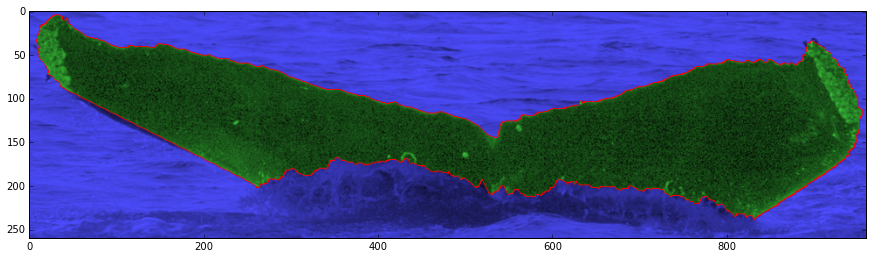

In [3]:
import random
test_id = random.choice(annotations_done.keys())
print(test_id)
test_info = ImageInfo(test_id)
test_info.load_info(annotations_done[test_id])

segmented_test = test_info.segment_img()
fig = plt.figure(figsize=(15,15))
segmented_ax = fig.add_subplot(111)
img_copy = np.copy(test_info.img)
img_copy[np.where(segmented_test != 1)] = 0.3*test_info.img[np.where(segmented_test != 1)]
print(test_info.bad_regions)
img_copy[np.where(test_info.border_img == 1)] = [255,0,0]
#img_copy[zip(*list(test_info.badPoints))[::-1]] = [255,0,0]

segmented_ax.imshow(img_copy)

In [4]:
test_samples = test_info.sample_img((64,64), 100)

In [5]:
len([sample[0].shape == (64,64,3) for sample in test_samples])

100

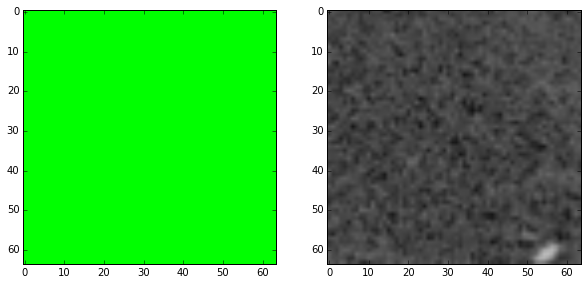

In [6]:
fig = plt.figure(figsize=(10,10))
segmented_ax = fig.add_subplot(121)
input_ax = fig.add_subplot(122)
random_sample = random.choice(test_samples)

segmented_ax.imshow(random_sample[1])
input_ax.imshow(random_sample[0])

In [7]:
import time
all_patches = []
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
all_whole_imgs = annotations_done.keys()
imgs_shuffled = shuffle(all_whole_imgs)
train_imgs, test_imgs = train_test_split(imgs_shuffled)
train_imgs, val_imgs = train_test_split(train_imgs)


def get_patches(imgids, sample_size=(32,32), n_samples=100):
    tic = time.time()
    patches = []
    for id_ in imgids:
        info = ImageInfo(id_)
        info.load_info(annotations_done[id_])
        info.segment_img()
        samples = info.sample_img(sample_size, n_samples)
        patches = chain(patches, samples)
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    return tuple(map(np.array,zip(*patches)))



sample_size=(64,64)
n_samples=100
train_patches, train_labels = get_patches(train_imgs, sample_size=sample_size, n_samples=n_samples)
val_patches, val_labels = get_patches(val_imgs, sample_size=sample_size, n_samples=n_samples)
test_patches, test_labels = get_patches(test_imgs, sample_size=sample_size, n_samples=n_samples)

Took 6.55 seconds
Took 2.13 seconds
Took 2.92 seconds


In [8]:
%load_ext autoreload
%autoreload 2
from train_utils import save_dataset

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______



Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled)


In [9]:
saveto = 'annot_full_64_100r_zs'

In [10]:
np.average(train_patches)

153.21690415793319

In [11]:
save_dataset(join(dataset_loc,'Flukes/patches/%s' % saveto),
             (train_patches, train_labels),
             (val_patches, val_labels),
             (test_patches, test_labels))

Overwriting /home/zach/data/Flukes/patches/annot_full_64_100r_zs y/n
y
Took 378.99 seconds


In [12]:
# let's save a downsampled version as well
limit = 64
save_dataset(join(dataset_loc,'Flukes/patches/TEST%s' % saveto),
             (train_patches[:limit], train_labels[:limit]),
             (val_patches[:limit], val_labels[:limit]),
             (test_patches[:limit], test_labels[:limit]), 
             load_norm_from=join(dataset_loc,'Flukes/patches/%s' % saveto))

Overwriting /home/zach/data/Flukes/patches/TESTannot_full_64_100r_zs y/n
y
Took 2.56 seconds


In [12]:
def get_whole(imgids):
    wholes = []
    for id_ in imgids:
        info = ImageInfo(id_)
        info.load_info(annotations_done[id_])
        info.segment_img()
        wholes.append((info.img, info.ground_truth))
    
    return tuple(map(list, zip(*wholes)))

train_whole = get_whole(train_imgs)
val_whole = get_whole(val_imgs)
test_whole = get_whole(test_imgs)

In [13]:
wholes = 'annot_full_whole'
save_dataset(join(dataset_loc,'Flukes/patches/%s' % wholes),
             train_whole, val_whole, test_whole)

Overwriting /home/zach/data/Flukes/patches/annot_full_whole y/n
y
Took 600.08 seconds


In [1]:
train_whole[1][0].shape

NameError: name 'train_whole' is not defined